## Summary  

<b>Many thanks to LiWei Hou, for helping me look at the code base and debug whilst changing the original dataframe from 1 sample at an iteration to minibatches.</b>

The seq2seq is the mainstream framework for neural machine translation. Most of today's commercial machine translation systems are based on it. In this assignment, we will use the Chinese and English text provided by NIST to train a simple Chinese-English translation system.  

Fundamentally, machine translation requires mapping an input sequence (words in the source language) to an output sequence (words in the target language). Recurrent Neural Networks (RNN) effectively handle this type of sequential data. An important difficulty in machine translation is that there is no one-to-one correspondence between input and output sequences. That is, sequences are often of different lengths, and word correspondences can be nontrivial (e.g., words that are directly translated from each other may not appear in the same order).  

To solve the above problem, we will use a more flexible architecture called seq2seq model. The model consists of two parts: encoder and decoder, both of which are RNN. The encoder takes as input a sequence of words in the source language and outputs the final hidden state of the RNN layer. The decoder is similar except that it has an additional fully connected layer (with softmax activation) that defines the probability distribution of the next word in the translation. In this way, the decoder essentially serves as a neural language model of the target language. The key difference is that the decoder uses the output of the encoder as its initial hidden state, rather than a vector of zeros.  

In this assignment, we first compared the performances of single/bi-directional GRU/RNN/LSTM models and chose the best network to proceed. Hyperparameter tuning experiments were run on hidden size and layer amount to find the best learner model under our task and data. The best performance without attention enabled has achieved 0.8728 on the validation set.

Among the networks we tested, GRU always has the best learning quality, whilst the RNN architecture is the worst. Using bidirectional networks significantly improves the performance of unidirectional networks. Bidirectional enhances context understanding by processing data in both forward and backward directions. The hidden state is a combination of information from both directions, enriching the model's comprehension. In speech recognition, Bidirectional RNNs capture nuanced patterns, improving accuracy.  

However, still, we could notice that the translation can miss semantic meanings. One of the major improvements could be made based on how we separate tokens from the source Chinese language. Currently, we extract Chinese tokens on a byte-base, yet using third-party segmentation modules could be expected to make significant progress, since the byte-based tokens are clearly missing grammar and semantic meanings, compared to subwords.  s


In [2]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu,SmoothingFunction
from easydict import EasyDict as edict

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

USE_CUDA = True

## 1 Data Preprocess

The source and target pair sentences are formated as below：

```
我很冷。    I am cold.
```

### 1.1 Embed Tokens to Integer index  

For each sentence in the source and the target language, three special symbols are introduced here, "SOS" means "Start of sentence" and "EOS" means "End of sentence". They are added to both ends of the input text to control the decoding process. “Padding” is used to fill the spaces if the sentence is not enough for a predefined maximum sequence length. 

In [3]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name,cn_cut='',en_cut = ''):
        self.name = name
        self.cn_cut = cn_cut
        self.en_cut = en_cut
        
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>", 2:"<PAD>"}
        self.n_words = 3 # Count SOS   EOS  and PAD
      
    def index_words(self, sentence):
        if self.name == 'cn': 
            # chinese tokens are extracted on byte-base
            for word in sentence:
                self.index_word(word)
        else:
            # chinese tokens are extracted on word-base
            for word in sentence.split(' '):
                self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### 1.2 Data Cleanup

It is a common practivce to remove puntuations and convert letters to lower-cases. 

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u4e00-\u9fa5,.!?，。！？]+", r" ", s)
    return s

In [5]:
def read_langs(lang1, lang2, reverse=False,cn_cut = '',en_cut = ''):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2),encoding='utf-8').read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2,cn_cut = cn_cut,en_cut = en_cut)
        output_lang = Lang(lang1,cn_cut = cn_cut,en_cut = en_cut)
    else:
        input_lang = Lang(lang1,cn_cut = cn_cut,en_cut = en_cut)
        output_lang = Lang(lang2,cn_cut = cn_cut,en_cut = en_cut)
        
    return input_lang, output_lang, pairs

### 1.3 Filter out too-long sentences

In order to speed up training, the sample only retains sentence pairs with no longer than a given word amount. In real practice, taking more data into consideration may achieve better results.

In [6]:
MAX_LENGTH = 50

def filter_pair(p):
    return len(p[1].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

The whole pipeline of processing data:

- Read the data, process each line separately, and convert them into sentence pairs
- Process text and filter out useless symbols
- Number words according to existing text and build a mapping vocabulary from symbols to numbers


In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False,cn_cut = '',en_cut=''):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse,cn_cut = cn_cut,en_cut = en_cut)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs



In [8]:
input_lang, output_lang, pairs = prepare_data('cn', 'eng', False)
# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 90000 sentence pairs
Trimmed to 89935 sentence pairs
Indexing words...
['我們看著夕陽西下。', 'we are watching the sun set .']


### 1.4 Convert text data to tensor

In order to train, we need to turn the sentences into something the neural network can understand (numbers). Each sentence will be broken into words and then turned into a tensor, where each word is replaced by an index (from the previous Lang index). When creating these tensors, we will also append an EOS token to indicate that the sentence has ended.

In this section, we also defined the collate_fn to adapt the built vocabulary and embedding to torch dataloader conventions. The code is inspired by: https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb 

In [9]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    if lang.name == 'cn':
        return [lang.word2index[word] for word in sentence]
    else:
        return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = [SOS_token]+indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = torch.LongTensor(indexes).view(-1, 1)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [10]:
def get_collate_fn(pad_index):
    def collate_fn(pairs):
        src = [variables_from_pair(pair)[0] for pair in pairs]
        trg = [variables_from_pair(pair)[1] for pair in pairs]
        
        # add padding if the sentence is not long enough
        src = nn.utils.rnn.pad_sequence(src, padding_value=pad_index)
        trg = nn.utils.rnn.pad_sequence(trg, padding_value=pad_index)
        
        batch = {
            "src": src,
            "trg": trg,
        }
        return batch

    return collate_fn

In [11]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

## 2 Model Architecture  

RNN, GRU and LSTM are examined as the encoder/decoder network. Three different networks have similar architectures, the below section will use the LSTM as an example to showcase the model flowchart.  

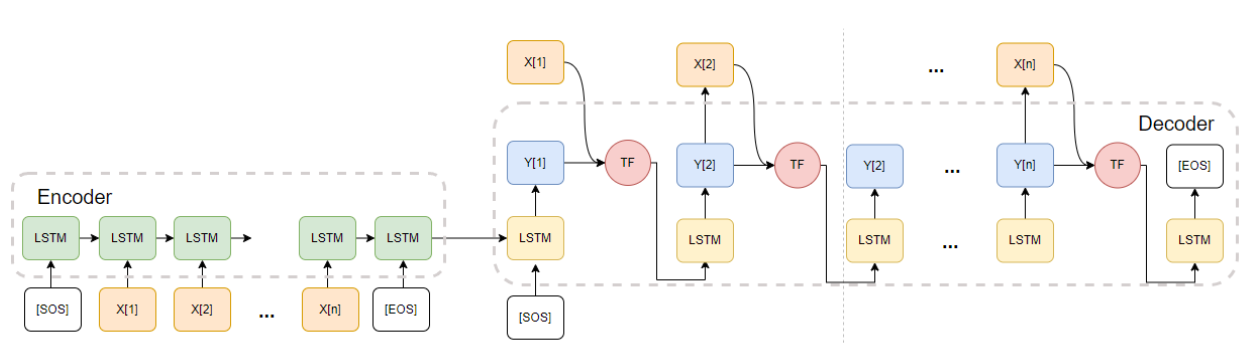  
Above is a diagram that showcases the architecture of the LSTM Seq2Seq model.  

The source sentence, as the input X(embedded), is passed into the encoder.  At each time-step, the input to the encoder is both the embedding of the current word, as well as the hidden state from the previous time-step. The hidden state is the representation of the sentence so far.  

Once the final work is processed by the encoder, we use the final output hidden state as a vector representation of the entire source sentence. At each time-step, the input to the decoder is both the embedding of the predicted word from the last timestep, as well as the hidden state from the previous time-step. Note that we added a teacher forcing mechanism(red) for the decoder. If the teacher forcing is enabled, the input for the decoder would be the word that corresponds to the ground truth of the previous time step, as well as the last hidden state.  

The code implementation is inspired by: https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

### 2.1 Encoder (No Attention)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2, net_type='RNN', bidirectional=True, dropout=0.5):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size  # source vocabnulary length
        self.hidden_size = hidden_size  # embed dim
        self.n_layers = n_layers
        self.net_type = net_type
        self.bidirectional = bidirectional # bool
        self.num_directions = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        if 'RNN' == net_type:
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, bidirectional=self.bidirectional, dropout=dropout)
        if 'GRU' == net_type:
            self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=self.bidirectional, dropout=dropout)
        if 'LSTM' == net_type:
            self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional=self.bidirectional, dropout=dropout)
        
    def forward(self, word_inputs):
        # Note: we run this all at once (over the whole input sequence)
        
        # word_inputs: (sequence length, batch size)
        seq_len = word_inputs.shape[0]
        batch_size = word_inputs.shape[1]
        # embedded: (sequence length, batch size, embed_dim)
        embedded = self.embedding(word_inputs).view(seq_len, batch_size, -1)

        # output: (sequence length, batch size, direction_amount*hidden_size)
        # hidden: (direction_amount*num_layers, batch_size, hidden_size)
        if 'RNN' == self.net_type:
            output, hidden = self.rnn(embedded)       
        if 'GRU' == self.net_type:
            output, hidden = self.gru(embedded)
        if 'LSTM' == self.net_type:
            # hidden is actually: (h, c)
            # h: (direction_amount*num_layers, batch_size, hidden_size)
            # c: (direction_amount*num_layers, batch_size, hidden_size)
            output, hidden = self.lstm(embedded)
        
        return output,hidden

### 2.2 Decoder (No Attention)

In [33]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=2, net_type='RNN', dropout=0.5):
        super(DecoderRNN, self).__init__()

        self.net_type = net_type
        self.output_size = output_size  # target vocabnulary length
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout # dropout rate
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        if 'RNN' == net_type:
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        if 'GRU' == net_type:
            self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        if 'LSTM' == net_type:
            self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)    
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden):
        # Note: we run this one step at each time step  
        seq_len = word_input.shape[0]
        batch_size = word_input.shape[1]  # here should be one since each word is a timestep

        # embedded: (1, batch size, embed_dim)
        word_embedded = self.embedding(word_input).view(seq_len,batch_size,-1)
        # output: (sequence length, batch size, direction_amount*hidden_size)
        # hidden: (direction_amount*num_layers, batch_size, hidden_size)
        if 'RNN' == self.net_type:
            rnn_output, hidden = self.rnn(word_embedded, last_hidden)    
        if 'GRU' == self.net_type:
            rnn_output, hidden = self.gru(word_embedded, last_hidden)         
        if 'LSTM' == self.net_type:
            # hidden is actually: (h, c)
            # h: (direction_amount*num_layers, batch_size, hidden_size)
            # c: (direction_amount*num_layers, batch_size, hidden_size)
            rnn_output, hidden = self.lstm(word_embedded, last_hidden)
        rnn_output = rnn_output.squeeze(0)
        # (batch_size, output_size)
        output = F.log_softmax(self.fc(rnn_output),dim=-1)

        return output, hidden

### 2.3 Attention

Traditional Seq2Seq model’s encoder compressed the whole source sentence into a single vector. This can be very hard to represent the actual sequence of words - the number of possible source sentences (hence, their meanings) is infinite. When the encoder is forced to put all information into a single vector, it is likely to forget something.  

This single vector representation also brings in limitations for the decoding process, since the decoder sees only one representation of source. However, at each generation step, different parts of the source can be more useful than others. This is the reason we introduce attention mechanisms.  

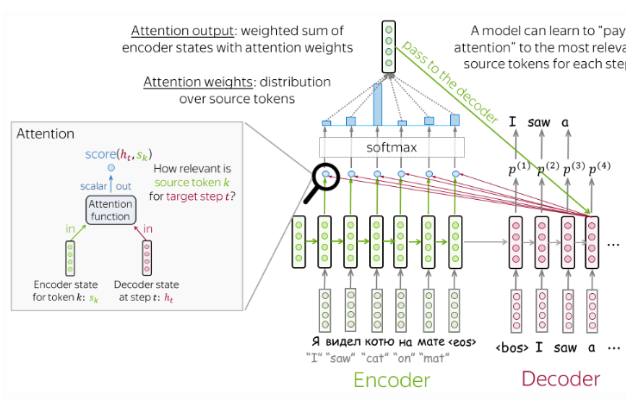  

At each decoder step, attention receives a decoder state and all encoder states, and compute the attention scores. For each encoder state , attention computes its "relevance" for this decoder state. Formally, it applies an attention function which receives one decoder state and one encoder state and returns a scalar value as the attention score. The attention weights are calculated by applying a Softmax over the attention scores. And finally the attention output is the weighted sum of encoder states with attention weights.  

<b>Due to the time restriction, Iwas srill in the debug stage for attention. So I'll not put it into the submission.</b>

### 2.4 Final Seq2Seq Model

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, config):
        super(Seq2Seq, self).__init__()
        
        self.bidirectional = config.bidirectional  # bool
        self.hidden_size = config.hidden_size
        self.n_layers = config.n_layers
        self.attention = config.attention
        
        input_size = config.in_n_words
        output_size = config.out_n_words
        net_type = config.net_type
        dropout = config.dropout 
        
        numdirections = 2 if config.bidirectional else 1
        
        self.encoder = EncoderRNN(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers,
                                  net_type=net_type, bidirectional=bidirectional, dropout=dropout)
        if self.attention:
            self.decoder = AttnDecoderRNN(output_size=output_size, embedding_size=hidden_size, hidden_size=hidden_size, 
                                          net_type=net_type, n_layers=n_layers, dropout=dropout)
        else:
            self.decoder = DecoderRNN(hidden_size=hidden_size, output_size=output_size, n_layers=numdirections*n_layers, 
                         dropout=dropout, net_type=net_type)

        self.use_cuda = config.use_cuda
        
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):    
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_size

        # tensor to store decoder outputs: (sequence_lenth, batch_size, output_size)
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size)
        if self.use_cuda:
            outputs = outputs.cuda()
            
        # output: (sequence length, batch size, direction_amount*hidden_size)    
        # hidden for GRU and RNN: (direction_amount*num_layers, batch_size, hidden_size)
        # hidden for LSTM: (direction_amount*num_layers, batch_size, hidden_size, direction_amount*num_layers, batch_size, hidden_size)
        encoder_outputs, encoder_hidden = self.encoder(src)
            
        if self.attention:
            if self.encoder.net_type == 'LSTM':
                encoder_hidden = (encoder_hidden[0][:self.decoder.n_layers], encoder_hidden[1][:self.decoder.n_layers])
            else:
                encoder_hidden = encoder_hidden[:self.decoder.n_layers]

        # initialize the first input to the decoder
        # o is the index for [SOS] token
        decoder_input = trg[0].unsqueeze(0)
        decoder_hidden = encoder_hidden

        # step though each timestep
        for t in range(1, trg_length):
            # calculate the probability logits
            if self.attention:
                output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            else:
                output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)    
            # output: (1, batch size, direction_amount*hidden_size)
            outputs[t] = output

            # if apply teacher forcing
            # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            top1 = top1.view(1,-1,1)

            decoder_input = trg[t].unsqueeze(0) if teacher_force else top1
    
        return outputs

In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

## 3 Training Pipeline

We defined the training and evaluating methods in this section.  

As introduced in Section 2, we introduce teacher forcing into the training. Teacher forcing is a fast and effective way to train a recurrent neural network that uses output from prior time steps as input to the model.  

But, the approach can also result in models that may be fragile or limited when used in practice when the generated sequences vary from what was seen by the model during training.  

Therefore, we added a random gate(probability) to choose whether to use teacher forcing for the next timestep.

### 3.1 Initial Configuration

In [28]:
config = edict(corpusfile = '',
               hidden_size=500,
               n_layers = 2,
               dropout= 0.5,
               net_type = 'RNN',
               bidirectional = False,
               attention = False,
               max_length = 15,
               epochs = 5,
               batch_size = 50,
               learning_rate = 0.001,
               teacher_forcing_ratio = 0.5,
               clip = 5.0,
               cn_cut = '',
               en_cut = '',
               use_cuda = True,
               in_n_words = None,
               out_n_words = None
              )

In [29]:
MAX_LENGTH = 50
input_lang, output_lang, pairs = prepare_data('cn', 'eng', reverse=False,cn_cut = config.cn_cut,en_cut=config.en_cut)
print(f"total pairs:{len(pairs):6d} | input words:{input_lang.n_words:6d} | output words:{output_lang.n_words:6d}")

config.in_n_words = input_lang.n_words
config.out_n_words = output_lang.n_words

batch_size = config.batch_size
pairs_train,pairs_dev = train_test_split(pairs, test_size=0.05, random_state=2024)

train_dataloader = get_data_loader(pairs_train, batch_size, PAD_token, shuffle=True)
val_dataloader = get_data_loader(pairs_dev, batch_size, PAD_token, shuffle=False)

Reading lines...
Read 90000 sentence pairs
Trimmed to 89935 sentence pairs
Indexing words...
total pairs: 89935 | input words:  4317 | output words: 13845


### 3.2 Train and Evaluation Pipeline  

Gradient Clipping is also used when updating with the optimizer. Gradient Clipping is a method where the error derivative is changed or clipped to a threshold during backward propagation through the network, and using the clipped gradients to update the weights. It is an effective strategy to fight again exploding gradients.

In [30]:
def train_one_epoch(train_dataloader, model, optimizer, criterion, config):
    teacher_forcing_ratio = config.teacher_forcing_ratio
    use_cuda = config.use_cuda
    clip = config.clip
    
    model.train()  
    epoch_loss = 0
    
    for i,batch in enumerate(train_dataloader):
        # (sequence_length, batch size)
        src = batch['src']
        trg = batch['trg']
        if use_cuda:
            src = src.cuda()
            trg = trg.cuda()
        
        optimizer.zero_grad()
        # output: (sequence_lenth, batch_size, output_size)
        output = model(src, trg, teacher_forcing_ratio)
        
        output_dim = output.shape[-1]
        output = output.view(-1,output_dim)  # (sequence_lenth*batch_size, output_size)
        
        trg = trg.view(-1)  # (sequence_lenth*batch_size)
        loss = criterion(output,trg)
        epoch_loss += loss.item()
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    return epoch_loss / len(train_dataloader)

In [18]:
def evaluate(val_dataloader, model, criterion, config):
    use_cuda = config.use_cuda
    
    model.eval()  
    epoch_loss = 0
    
    for i,batch in enumerate(val_dataloader):
        # (sequence_length, batch size)
        src = batch['src']
        trg = batch['trg']
        if use_cuda:
            src = src.cuda()
            trg = trg.cuda()
            
        # output: (sequence_lenth, batch_size, output_size)
        output = model(src, trg, 0) # turn off the teacher forcing while making inferences
        
        output_dim = output.shape[-1]
        output = output.view(-1,output_dim) # (sequence_lenth*batch_size, output_size)
        
        trg = trg.view(-1)
        
        loss = criterion(output,trg)
        epoch_loss += loss.item()
    
    return epoch_loss / len(val_dataloader)

In [19]:
def translate_sentence(model, sentence, max_length=MAX_LENGTH):
    
    model.eval()
    
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    encoder_outputs, encoder_hidden = model.encoder(input_variable)    
    if model.attention:
        if model.encoder.net_type == 'LSTM':
            encoder_hidden = (encoder_hidden[0][:model.decoder.n_layers], encoder_hidden[1][:model.decoder.n_layers])
        else:
            encoder_hidden = encoder_hidden[:model.decoder.n_layers]

    # Create starting vectors for decoder
    decoder_input = torch.LongTensor([[SOS_token]]) # SOS
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for t in range(max_length):
        if model.attention:
            decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden,encoder_outputs)
        else:
            decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)
        
        # Choose word with the highest probability from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            # if is EOS, end the sentence inference
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = torch.LongTensor([[ni]])
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words

In [31]:
def evaluate_randomly(model, pairs):
    """
    Display the source/target sentences and translation;
    One pair at a time.
    """
    pair = random.choice(pairs)
    
    output_words = translate_sentence(model,pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [32]:
def calc_bleu(model,pairs):
    gt = [[pair[1].split(' ')] for pair in pairs] # ground tryth
    out = [translate_sentence(model,pair[0]) for pair in pairs]
    bleu = corpus_bleu(gt, out)
    
    return bleu

In [22]:
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [23]:
def train(model,train_dataloader,valid_dataloader,config,prefix=''):
    # Move models to GPU
    if config.use_cuda:
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.NLLLoss()
    
    best_bleu = 0.0
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    bleus = []
    not_improve = 0  # early stop
    
    for epoch in range(1,config.epochs+1):
        print("At epoch: {}".format(epoch))

        if (not_improve+1) % 5 == 0:
            adjust_learning_rate(optimizer,0.5)


        train_loss = train_one_epoch(train_dataloader, model, optimizer, criterion, config)
        valid_loss = evaluate(val_dataloader, model, criterion, config)

        bleu = calc_bleu(model,pairs_dev)
        bleus.append(bleu)
        if bleu > best_bleu:
            best_bleu = bleu
            torch.save(model.state_dict(), prefix+"_best_bleu-model.pt")
            not_improve = 0
        else:
            not_improve += 1

        print(f"Epoch: {epoch:3d} | Train Loss: {train_loss:7.4f}" + 
              f" | Valid Loss: {valid_loss:7.4f} | Valid BLEU: {bleu:7.4f} | Not improve: {not_improve:3d}")

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if not_improve>=10:
            break

    torch.save(model.state_dict(), prefix+"final-model.pt")
    
    return train_losses,valid_losses,bleus,best_bleu

In [ ]:
def visualize_logs(train_losses, val_losses, val_bleus, labels):
    # labels are name(prefix) for the model we run and test

    # two columns
    # one for train and val loss, one for bleu scores on val set
    fig,ax = plt.subplots(nrows =1,ncols = 2,figsize = (20,10))

    # draw loss curves
    i = 0  # for color changing
    for train_loss, val_loss, label in zip(train_losses, val_losses, labels):
        color = "C{}".format(i)
        
        ax[0].plot(train_loss, color=color, linestyle="-", label=label+'_train')
        ax[0].plot(val_loss, color=color, linestyle="-.", label=label+'_dev')
        i += 1 # update color
    ax[0].legend()
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')

    # draw bleu score curves on the dev set 
    i = 0
    for bleu, label in zip(val_bleus, labels):
        color = "C{}".format(i)
        ax[1].plot(bleu, color=color, label = label)
        i += 1

    ax[1].legend()
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('bleu')

## 4 Parameter Tuning and Model Comparison  

We will investigate how different encoder/decoder networks can affect the translation quality, and if adding in attention can significantly improve the translation model performances.  

Loss and BLEU scores are used to evaluate the model performance. BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human. Although it is one of the most popular evaluation metrics for NLP tasks, it has some limitations. BLEU score heavily relies on n-grams and may not capture the overall meaning or fluency of the translated text accurately. It may also penalize translations that are longer than the reference translations, which can be unfair in some cases.

### 4.1 Comparison between RNN/GRU/LSTM (No Attention, No Bi-direction)  

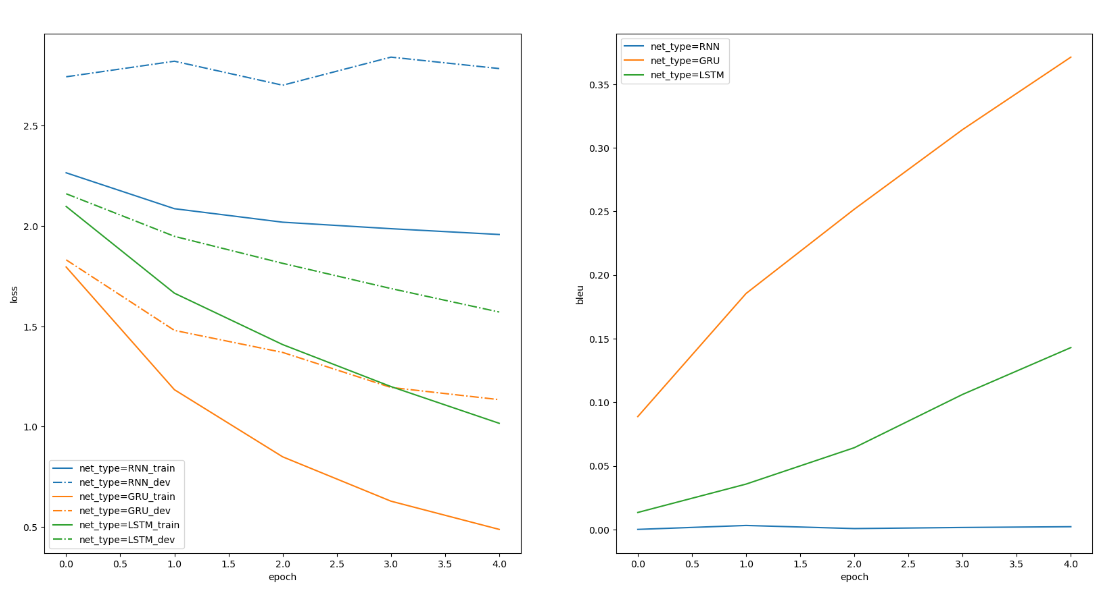  

<b>Observations:</b>
1. Chart 1 is a visualization of the loss of the model on the training set and validation set, and Chart 2 is the BLEU score translated by the model on the validation set.  
2. GRU is the best performer among the three models tested, and the BLEU score of its translated sentences far exceeds the other two networks.
3. The translation model based on RNN is the slowest to converge, and its loss on the verification set has almost no significant decrease, and there is an obvious overfitting trend in only 5 epochs.
4. he translation score of the RNN-based framework on the verification set is infinitely close to 0, and the model has not learned enough information to make effective inferences.


### 4.2 Comparison between RNN/GRU/LSTM (No Attention, Bi-direction)  

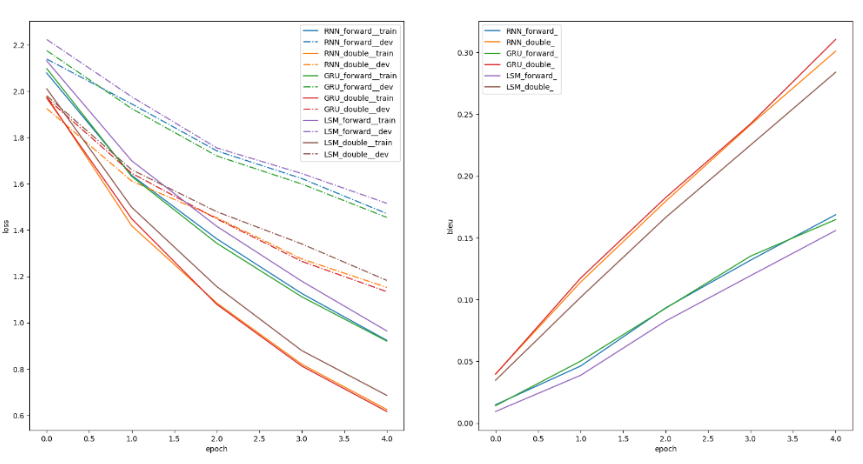  

1. As expected, GRU is still the best-performing network structure, and its BLEU score for inference on the validation set significantly exceeds that of other networks.  
2. Using bidirectional networks significantly improves the performance of unidirectional networks. Bidirectional enhances context understanding by processing data in both forward and backward directions. The hidden state is a combination of information from both directions, enriching the model's comprehension. In speech recognition, Bidirectional RNNs capture nuanced patterns, improving accuracy.
3. Surprisingly, after using the bidirectional RNN structure, the model performed better than the LSTM results. Even the performance of bidirectional RNN and bidirectional GRU is extremely close.
4. Below is a diagram comparing these three networks: 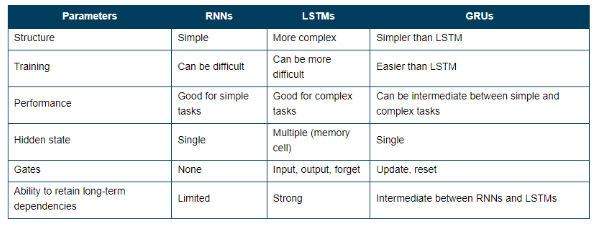
5. We will choose GRU with bi-directional for later parameter tuning.

### 4.3 Batch Size  

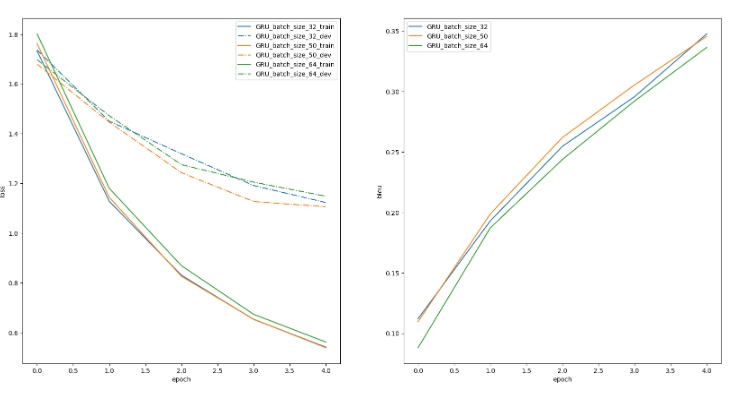    

It can be seen from the figure that when the batch size is set to 32 and 50, the performance of the model is relatively close. Although the performance of batch size 50 has been better than that of batch size 32 in the first four epochs, the BLEU score of batch size 32 in the last epoch significantly exceeded that of batch size 50, and there is still an upward trend. So we will use batch size 32 as the basis for subsequent parameter adjustment.

### 4.4  Hidden Size  

We will use bi-directional GRU with 5 epochs to test the hidden size. The batch size is set to 32. The hidden dimension sizes examined are: [128, 256, 512].  

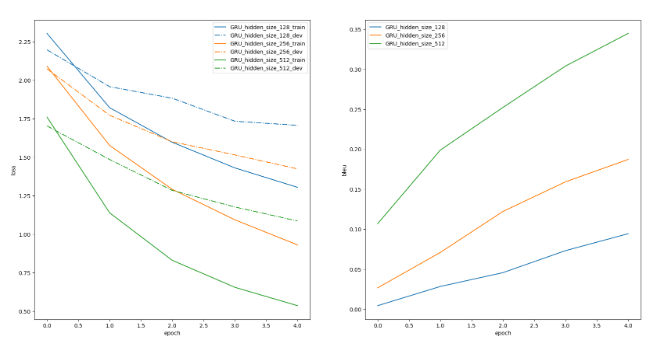  

The dimension of LSTM hidden states can have an impact on the performance of the model. A larger dimension can potentially allow the model to capture more complex patterns in the data, leading to better performance in tasks such as language modeling, machine translation, and speech recognition. However, increasing the dimension also increases the number of parameters in the model, which can lead to longer training times and increased computational requirements. Additionally, the optimal dimension may vary depending on the specific task and dataset, so it's often a matter of experimentation to find the best setting for a particular application.  

As can be observed from the diagram above, the greater the hidden dimension is, the faster the model converges, and the better translation the model inference on the validation set. Therefore, we will use 512 as the hidden dimension in the later experiments.  

In addition, since we can see that 512(the greatest dimension we have in the test) has the best performance, we could assume that the best solution would be a value greater than 512. However, due to the limitation of time, we did not run further testing.  



### 4.5 Number of layers  

We will use bi-directional GRU with 5 epochs and 512 as the hidden size. The batch size is set to 32. Layer amounts examined are: [1, 2, 4, 8].  

1. When the number of GRU layers is set to 1 or 2, the performance of the two on the validation set is close. The model with a layer number of 2 initially performs better than a model with a layer number of 1, but becomes worse than the model with a layer number of 1 at about the 3-4 epoch. 
e2. The deeper the number of layers in the model, the worse the performance of the model. Especially when the number of layers is set to 8, you can see that there is almost no change in the loss curve and BLEU curve of the model. Deeper neural networks can sometimes perform worse than shallower ones due to the vanishing gradient problem and overfitting. The vanishing gradient problem occurs when the gradients of the loss function become extremely small as they are back-propagated through the network, making it difficult for the lower layers to learn effectively. This can hinder the training of deeper networks. Additionally, deeper networks can be more prone to overfitting, especially when the amount of training data is limited.

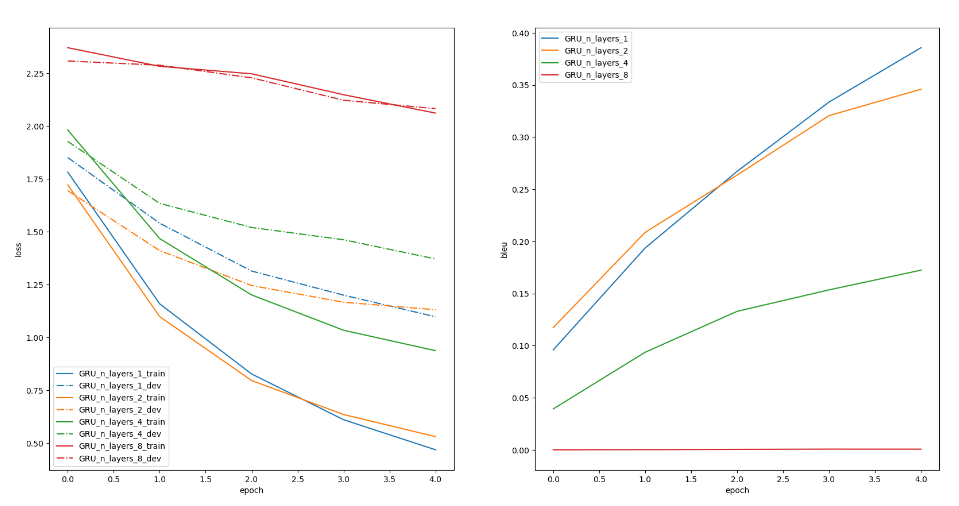

l


In [ ]:
train_losses = []
valid_losses = []
all_bleus = []
best_bleus = []
prefixes = []

params = {'name':'net_type','value':['RNN','GRU','LSTM']}

for param in params['value']:
    print("net is:{}".format(param))
    config[params['name']] = param
    
    prefix = net + "_" + param # for saving model checkpoint and visualize logs
    prefixes.append(prefix)

    model = Seq2Seq(config)
    model.apply(init_weights)

    train_loss, valid_loss, bleus, best_bleu = train(model, train_dataloader, val_dataloader, config, prefix=prefix)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    all_bleus.append(bleus)
    best_bleus.append(best_bleu)
    
    print("train_losses: {}".format(str(train_losses_tmp)))
    print("val_losses: {}".format(str(valid_losses_tmp)))
    print("blue: {}".format(str(bleus_tmp)))

In [113]:
visualize_logs(train_losses, val_losses, all_bleus, prefixes)

## 5 Final Model


In [ ]:
config = edict(corpusfile = '',
               hidden_size=512,
               n_layers = 1,
               dropout_p=0.05,
               net_type = 'GRU',
               bidirectional = 'double',
               attention = False,
               max_length = 10,
               epochs = 50,
               batch_size = 32,
               learning_rate = 0.001,
               teacher_forcing_ratio = 0.5,
               clip = 5.0,
               cn_cut = '',
               en_cut = '',
               use_cuda = True,
               in_n_words = None,
               out_n_words = None
              )

MAX_LENGTH = 50
input_lang, output_lang, pairs = prepare_data('cn', 'eng', reverse=False,cn_cut = config.cn_cut,en_cut=config.en_cut)
print(f"total pairs:{len(pairs):6d} | input words:{input_lang.n_words:6d} | output words:{output_lang.n_words:6d}")

config.in_n_words = input_lang.n_words
config.out_n_words = output_lang.n_words

batch_size = config.batch_size
pairs_train,pairs_dev = train_test_split(pairs, test_size=0.05, random_state=2020)
train_dataloader = get_data_loader(pairs_train, batch_size, PAD_token, shuffle=True)
val_dataloader = get_data_loader(pairs_dev, batch_size, PAD_token, shuffle=False)

In [ ]:
train_losses = []
valid_losses = []
bleus = []
best_bleus = []

for param in params['value']:
    config[params['name']] = param
    
    prefix = f"{params['name']}={param}_"
    print(prefix)

    model = Seq2Seq(config)
    model.apply(init_weights)

    train_losses_tmp,valid_losses_tmp,bleus_tmp,best_bleu = train(model,train_dataloader,val_dataloader,config,prefix = prefix)
    train_losses.append(train_losses_tmp)
    valid_losses.append(valid_losses_tmp)
    bleus.append(bleus_tmp)
    best_bleus.append(best_bleu)

## Generate Outputs from Test Data

In [120]:
config = edict(corpusfile = '',
               hidden_size=512,
               n_layers = 1,
               dropout_p=0.05,
               net_type = 'GRU',
               bidirectional = 'double',
               attention = False,
               max_length = 10,
               epochs = 50,
               batch_size = 32,
               learning_rate = 0.001,
               teacher_forcing_ratio = 0.5,
               clip = 5.0,
               cn_cut = '',
               en_cut = '',
               use_cuda = True,
               in_n_words = None,
               out_n_words = None
              )  

MAX_LENGTH = 50
input_lang, output_lang, pairs = prepare_data('cn', 'eng', reverse=False,cn_cut = config.cn_cut,en_cut=config.en_cut)
print(f"total pairs:{len(pairs):6d} | input words:{input_lang.n_words:6d} | output words:{output_lang.n_words:6d}")

config.in_n_words = input_lang.n_words
config.out_n_words = output_lang.n_words

batch_size = config.batch_size
pairs_train,pairs_dev = train_test_split(pairs, test_size=0.05, random_state=2020)
train_dataloader = get_data_loader(pairs_train, batch_size, PAD_token, shuffle=True)
val_dataloader = get_data_loader(pairs_dev, batch_size, PAD_token, shuffle=False)

Reading lines...
Read 90000 sentence pairs
Trimmed to 90000 sentence pairs
Indexing words...
total pairs: 90000 | input words: 28409 | output words: 13974


In [121]:
model = Seq2Seq(config)
if config.use_cuda:
    model.cuda()
model.load_state_dict(torch.load("attention=True_best_bleu-model.pt"))
model

Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(28409, 500)
    (gru): GRU(500, 500, num_layers=2, bidirectional=True)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(13974, 500)
    (lstm): GRU(1000, 500, num_layers=2, dropout=0.05)
    (attention): Attention(
      (attn1): Linear(in_features=1000, out_features=500, bias=True)
      (attn2): Linear(in_features=500, out_features=1, bias=True)
    )
    (out): Linear(in_features=1000, out_features=13974, bias=True)
  )
)

In [122]:
lines = open('test.txt',encoding='utf-8').read().strip().split('\n')   
sents = [normalize_string(s) for s in lines] 

for sent in sents:
    for word in jieba.cut(sent):
        if word not in input_lang.word2index.keys():
            input_lang.word2index[word] = PAD_token
            
        
with open('result.txt','w') as f:
    for sent in sents:
        
        output_words = translate_sentence(model,sent)
        output_sentence = ' '.join(output_words)
        
        output_sentence += '\n'
        f.write(output_sentence)
        
    